# Setup and config

In [1]:
# Imports and setup
from CNN.backend import load_or_train_CNN
from CNN.plotting import plot_confusion_matrix, plot_loss

from SVD.back import visualize_svd, compute_svd_per_digit, classify_image, load_or_run_all_ranks

from pathlib import Path

from torchvision import datasets


from pathlib import Path
import argparse

In [2]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.linalg import svd
import time
import pickle

In [3]:
# Set pathing correctly
path_download = Path.cwd() / 'data'

path_svd = Path.cwd() / 'SVD'

print(path_download)

path_raw_data = Path.cwd() / 'data'/ 'MNIST' / 'raw'
path_CNN_results = Path.cwd() / 'CNN' / 'results'

e:\OneDrive - TU Eindhoven\_doing_2WH30_Mathematical Modelling\REPO\Mathematical-Modelling\data


In [4]:
# Download data if not already present (pytorch implementation)
# Put in data folder earlier described
# d1 and d2 are dummy variables besides that!
d1 = datasets.MNIST(path_download, train=True, download=True)
d2 = datasets.MNIST(path_download, train=False)

# Common code 

In [4]:
# Logic handling the importing of images straight from the files.

# Load images from the MNIST dataset
def load_image_file(filename):
    with open(filename, 'rb') as f:
        # Skip the magic number and number of images
        _, num_images = struct.unpack(">II", f.read(8))
        rows, cols = struct.unpack(">II", f.read(8))  # Image dimensions
        # Read image data and reshape into (num_images, rows*cols)
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows * cols)
    return {'n': num_images, 'x': images}

# Load labels from the MNIST dataset
def load_label_file(filename):
    with open(filename, 'rb') as f:
        # Skip the magic number and number of labels
        _, num_labels = struct.unpack(">II", f.read(8))
        # Read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# Load training and test datasets
def load_mnist(folder: Path):
    train = load_image_file(folder / 'train-images-idx3-ubyte')
    test = load_image_file(folder /'t10k-images-idx3-ubyte')
    
    train['y'] = load_label_file(folder / 'train-labels-idx1-ubyte')
    test['y'] = load_label_file(folder / 't10k-labels-idx1-ubyte')
    
    return train, test

# Display an MNIST digit image
def show_digit(arr784):
    plt.imshow(arr784.reshape(28, 28), cmap='gray')
    plt.axis('off')  # Hide axes for cleaner display
    plt.show()



In [5]:
# Loading data
# Load MNIST data
train, test = load_mnist(path_raw_data)

# EDA

In [ ]:
# Display an example image (e.g., the 5th training image)
show_digit(train['x'][5])

In [ ]:
test_labels = load_label_file(path_raw_data / 't10k-labels-idx1-ubyte')
test_images = load_image_file(path_raw_data /  't10k-images-idx3-ubyte')

print(f"Number of test labels: {len(test_labels)}")
print(f"Number of test images: {len(test_images)}")

print(test_labels)

train_labels = load_label_file( path_raw_data / 'train-labels-idx1-ubyte')
train_images = load_image_file(path_raw_data /  'train-images-idx3-ubyte')
train_labels
train['y'][5]

In [ ]:
visualize_svd(train['x'][0])

In [ ]:
#Example image
for i in range(0,10):
    visualize_svd(train['x'][i])

# CNN

In [4]:
# Load / Define model / Set up settings for the model. 
parser = argparse.ArgumentParser(description='PyTorch MNIST Example');
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=40, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                    help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                    help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10000, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=True,
                    help='For Saving the current Model')

In [5]:
# Show architecture

In [ ]:
# Load or train the model
# Can set force to true if you want to force it to retrain
results:dict = load_or_train_CNN(path_CNN_results, path_download, force=True, parser=parser)

In [ ]:
# Plot losses
plot_loss(results=results, save_folder= path_CNN_results, show=True)

In [ ]:
# Plot confusion matrices of the last epoch
max_epoch = results["epochs"]
plot_confusion_matrix(results=results, epoch=max_epoch, save_folder=path_CNN_results, show=True)

In [ ]:
# Plot confusion matrices of the last epoch
best_epoch = results["best_epoch"]
plot_confusion_matrix(results=results, epoch=best_epoch, save_folder=path_CNN_results, show=True)

In [ ]:
# Neatly print the most important results.
print(f"Prep time: {results['prep_time']}, prediction time: {results['predict_time']}, (average of {results['predict_time']/10000})") 
      
print(f"Accuracy in best epoch: {results['best_epoch_accuracy']}, Accuracy in final epoch: {results['final_epoch_accuracy']}")

In [ ]:
results

# KNN

# SVD

The first thing for this section that we do will be time-intensive. So you CAN re-run this next cell, with force=True, to force all the svds to be re-ran, but a pre-ran pickled file will be present to more quickly grab the results. 

In [6]:
# We loop over all (rank 1-9 are omitted because they perform badly) ranks such that we can compute which rank works best
array_t1 = []
array_t2 =[]
accuracy_list = []
array_svd = []

rank_range = [i for i in range(10,31)]
array_t1, array_t2, accuracy_list, array_svd = load_or_run_all_ranks(train, test, rank_range, path_svd)

SVD file exists
SVD file loaded


In [7]:
# Figure out what rank was best performing
max_index = accuracy_list.index(max(accuracy_list))
best_rank = rank_range[max_index]

print(f"The best performing rank is {best_rank} with an accuracy of {accuracy_list[max_index]}")

The best performing rank is 23 with an accuracy of 0.9585


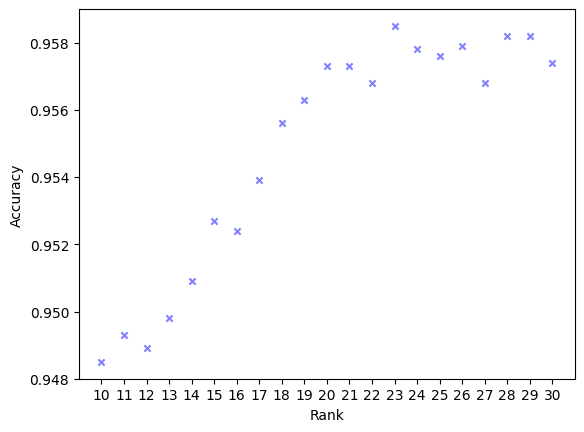

In [8]:
x= np.array(rank_range)
y= np.array(accuracy_list)
plt.xticks(rank_range)
plt.scatter(x, y, color='blue', alpha=0.5, s = 20,marker = 'x')
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.show()

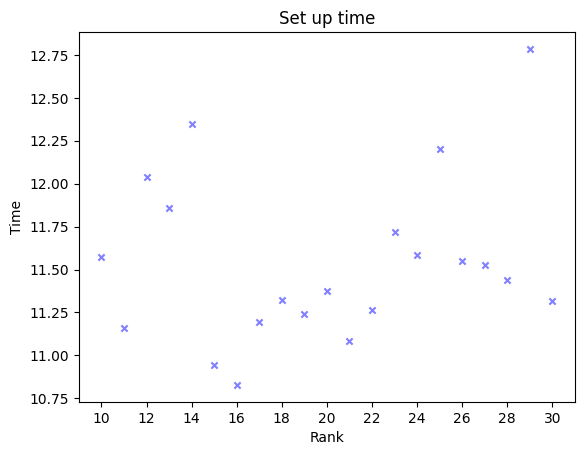

In [9]:
x= np.array(rank_range)
y= np.array(array_t1)
plt.scatter(x, y, color='blue', alpha=0.5, s = 20,marker = 'x')
plt.xlabel('Rank')
plt.ylabel('Time')
plt.title('Set up time')
plt.xticks(np.arange(min(x), max(x)+2, 2))
plt.show()


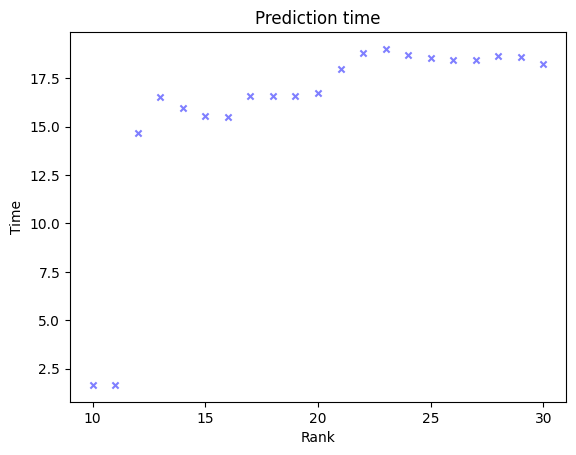

In [10]:
x= np.array(rank_range)
y= np.array(array_t2)
plt.scatter(x, y, color='blue', alpha=0.5, s = 20,marker = 'x')
plt.xlabel('Rank')
plt.ylabel('Time')
plt.title('Prediction time')
plt.xticks(np.arange(min(x), max(x)+2, 5))
plt.show()

We now know that rank 23 is preferred . The accuracy is best and the computation time is not significantly different from other ranks. With this rank we shall do the computations again to get a more accurate depiction of train / test time. And we shall plot a confusion matrix.

In [11]:
# Re-load data, to get a more accurate timing of rank 23 specifically
start_time_1 = time.perf_counter()
train1, test1 = load_mnist(path_raw_data)

r=23  
X_train = train1['x']  # Training images
y_train = train1['y']  # Training labels

X_test = test1['x']  # Test images
y_test = test1['y']  # Test labels

# Compute SVD for each class, digits from 0-9
svd_dict = compute_svd_per_digit(X_train, y_train, r)
end_time_1 = time.perf_counter()

# Compute time taken.
time_1 = end_time_1 - start_time_1
print(f"Ran the SVD operations for rank {r} in {time_1} seconds")

Ran the SVD operations for rank 23 in 10.9590794 seconds


In [16]:
# Classify test images again
start_time_2 = time.perf_counter()
train2, test2 = load_mnist(path_raw_data)

r=23  
X_train = train2['x']  # Training images
y_train = train2['y']  # Training labels

X_test = test2['x']  # Test images
y_test = test2['y']  # Test labels
predictions = np.array([classify_image(image, svd_dict) for image in X_test])
accuracy = np.mean(predictions == y_test)
end_time_2 = time.perf_counter()
time_2 = end_time_2 - start_time_2

print(f"Accuracy: {accuracy} with rank:{r}, this took {time_2} seconds")

Accuracy: 0.9585 with rank:23, this took 18.46382319999998 seconds


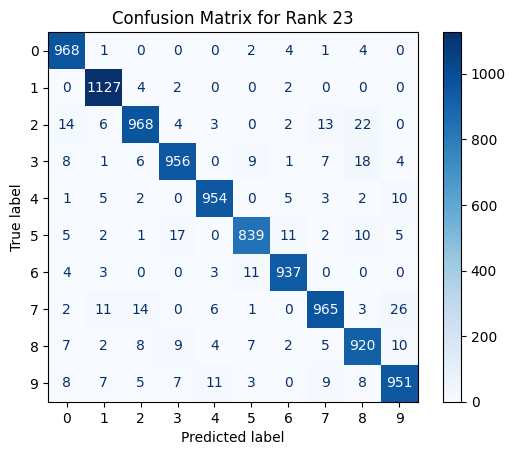

In [17]:
conf_matrix = confusion_matrix(y_test, predictions, labels=np.arange(10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for Rank {r}")
plt.show()